In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
test_load = nib.load('Task04_Hippocampus/Task04_Hippocampus/imagesTr/hippocampus_003.nii').get_fdata()
test_load.shape

(34, 52, 35)

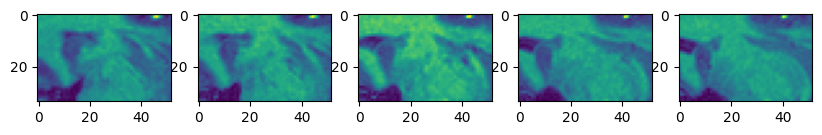

In [4]:
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(test_load[:,:,20 + i])
    plt.gcf().set_size_inches(10, 10)
plt.show()

### In this part, we try to train the UNet for image segmentation

In [1]:
import torch
import torchvision 
from torch import nn
import torch.nn.functional as F
from torch import optim
import numpy as np
# always check your version
print(torch.__version__)

1.13.1+cpu


### Build Basic UNet. Note we're working on 3D datasets

In [7]:
# Step 1: Build a nn.Sequential with two conv-BatchN-Relu layers
def baseblock(channel_in, channel_out):
#     Design a baseblock with conv-batch-relu x 2 (each input is twice convolved as in fig.)
    return nn.Sequential(
        # your code here
        nn.Conv3d(in_channels=channel_in,
                  out_channels=channel_out,
                  kernel_size=3, 
                  padding=1
                 ),
        nn.BatchNorm3d(num_features=channel_out),
        nn.ReLU(),
        
        nn.Conv3d(in_channels=channel_out,
                  out_channels=channel_out,
                  kernel_size=3, 
                  padding=1
                 ),
        nn.BatchNorm3d(num_features=channel_out),
        nn.ReLU(),
        
    )  

# Step 2: Build a downscaling module [Hint: use the above layeredConv after that]
# Add a maxpool before baseblock as in figure
def downsamplePart(channel_in, channel_out):
    return nn.Sequential(
            #your code,
            nn.MaxPool3d(kernel_size=2),
            baseblock(channel_in, channel_out)
        )

# Step 3: Build a upscaling module [Hint: use the above layeredConv after that]
# - Remember there is also concatenation and size may change so we are padding
class upsampledPart(nn.Module):
    def __init__(self, channel_in, channel_out, bilinear=True):
        super().__init__()
        #self.up = nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=True)
        self.up = nn.ConvTranspose3d(channel_in, channel_out, kernel_size=2, stride=2)
        self.conv = baseblock(channel_in, channel_out)
        
    def forward(self, x1, x2):
        # upscale and then pad to eliminate any difference between upscaled and other feature map coming with skip connection     
        x1 = self.up(x1)
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2] )
        
        # concatenate (perform concatenation of x1 and x2 --> remember these are skip x2(from encoder) and upssampled image x1)
        x = torch.cat([x2, x1], dim=1)
        
        # apply baseblock after concatenation --> you do again two convs.? --> baseblock
        x = self.conv(x)

        return x
    
# Step 4: Compile all of above together
# here output channel should be equal to number of classes
class UNet(nn.Module):
    def __init__(self, channel_in=1, channel_out=3, bilinear=None):
        super(UNet,self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        
        #call your base block
        self.initial = baseblock(channel_in, 64)
        
        # downsampling layers with 2 conv layers
        self.down1 = downsamplePart(64, 128)
        self.down2 = downsamplePart(128, 256)
        self.down3 = downsamplePart(256, 512)
        self.down4 = downsamplePart(512, 1024)
        
        # your code here
        # upsampling layers with feature concatenation and 2 conv layers 
        self.up1 = upsampledPart(1024, 512) 
        self.up2 = upsampledPart(512, 256)
        self.up3 = upsampledPart(256, 128)
        self.up4 = upsampledPart(128, 64)
        
        # output layer
        self.out = nn.Conv3d(64, channel_out, kernel_size=1) 

    # build a forward pass here
    # remember to keep your output as you will need to concatenate later in upscaling
    def forward(self,x):
        x1 = self.initial(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # your code here for upscaling
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # output
        return self.out(x) 

In [8]:
# call you model 
model = UNet(channel_in=1, channel_out= 3)
lr = 0.001
# optimiser = optim.Adam(model.parameters(), lr=lr)
# Optimiser
optimiser = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# optimiser = torch.optim.RMSprop(model.parameters(), lr = lr, weight_decay = 1e-8, momentum=0.9)
# TODO: you can try with different loss function
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [9]:
# Create metrics
def dice(a, b):
    """Calculate dice score for each image in tensor"""
    # a and b are tensors of shape (B, C, H, W)
    # Sum over last two axes (H and W i.e. each image)
    return 2*(a*b).sum(axis=[-2, -1])/(a + b).sum(axis=[-2,-1]).type(torch.float32)

def mask_out(out):
    """Mask tensor/array with 0 threshold"""
    # Need to binarize the output to be able to calculate dice score
    return np.argmax(out,axis=1)

def get_dice_arr(out, label):
    """Get dice score for each image in the batch for each mask seperately"""
    # Output is shape (B, C)
    return dice(mask_out(out), label)

def get_accuracy(out,label):
    return np.sum(mask_out(out)==label)/torch.numel(label)

In [10]:
x = np.random.uniform(size=(4,3,2))
x = torch.from_numpy(x)
print(x)
print(mask_out(x))

tensor([[[0.0340, 0.0810],
         [0.2707, 0.4238],
         [0.0663, 0.7497]],

        [[0.2883, 0.9724],
         [0.5330, 0.4340],
         [0.2123, 0.6178]],

        [[0.3101, 0.9960],
         [0.7619, 0.4671],
         [0.0878, 0.8106]],

        [[0.1077, 0.5505],
         [0.2365, 0.5196],
         [0.6872, 0.9913]]], dtype=torch.float64)
tensor([[1, 2],
        [1, 0],
        [1, 0],
        [2, 2]])


In [ ]:
# Training & validation: same as your classification task!!
model.to(device)
model.train()
# Tensorboard
from torch.utils.tensorboard import SummaryWriter
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

# define no. of epochs you want to loop 
epochs = 10
log_interval = 7 # for visualising your iterations 

# New: savining your model depending on your best val score
best_valid_loss = float('inf')
ckptFileName = 'UNet_hippocampus_best.pt'
for epoch in range(epochs):
    train_loss, valid_loss, train_dsc,val_dsc  = [], [], [], []
    
    for batch_idx, (data, label) in enumerate(traindataloader):
        # initialise all your gradients to zer

        label = label.to(device)
        optimiser.zero_grad()
        out = model(data.to(device))

        loss = criterion(out, label)
        loss.backward()
        optimiser.step()
        
        # append
        train_loss.append(loss.item())
        acc_1 = get_dice_arr(out, label.to(device))
        train_dsc.append(acc_1.mean(axis=0).detach().cpu().numpy())
        
        if (batch_idx % log_interval) == 0:
            print('Train Epoch is: {}, train loss is: {:.6f} and train dice: {:.6f}'.format(epoch, np.mean(train_loss),np.mean(train_dsc)))
        
            with torch.no_grad():
                ### We add model.eval() during evalation.
                model.eval()
                for i, (data, label) in enumerate(valdataloader):
                    data, label = data.to(device), label.to(device)
                    out = model(data)
                    loss = criterion(out, label.to(device))
                    #acc_1 = get_dice_arr(out, label.to(device))
                    acc_1 = get_accuracy(out,label.to(device))

                    # append
                    val_dsc.append(acc_1.mean(axis=0).detach().cpu().numpy())
                    valid_loss.append(loss.item())
    
            print('Val Epoch is: {}, val loss is: {:.6f} and val dice: {:.6f}'.format(epoch, np.mean(valid_loss), np.mean(val_dsc)))
    
    # Uncomment it to save your epochs
    if np.mean(valid_loss) < best_valid_loss:
         best_valid_loss = np.mean(valid_loss)
         print('saving my model, improvement in validation loss achieved...')
         torch.save(model.state_dict(), ckptFileName)
        
        
    # every epoch write the loss and accuracy (these you can see plots on tensorboard)        
    writer.add_scalar('UNet/train_loss', np.mean(train_loss), epoch)
    writer.add_scalar('UNet/train_accuracy', np.mean(train_dsc), epoch)
    
    # New --> add plot for your val loss and val accuracy
    writer.add_scalar('UNet/val_loss', np.mean(valid_loss), epoch)
    writer.add_scalar('UNet/val_accuracy', np.mean(val_dsc), epoch)
    
writer.close()